<a href="https://colab.research.google.com/github/menon92/DL-Sneak-Peek/blob/master/train_image_classifire_from_scratch_using_subclass_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import glob
import random
import pathlib
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models

In [2]:
# dataset link
DATASET_URL = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'

# download and untar the image dataset
data_dir = tf.keras.utils.get_file(
    origin=DATASET_URL,
    fname='flower_photos',
    untar=True
)
print('Dataset directory:', data_dir)

Dataset directory: /root/.keras/datasets/flower_photos


In [3]:
# show what contarins the data directory
os.listdir(data_dir)

['LICENSE.txt', 'sunflowers', 'dandelion', 'tulips', 'daisy', 'roses']

In [4]:
# flower name to integer label maping
FLOWER_NAME_TO_INT_LABEL = {'tulips': 0, 'dandelion': 1, 'roses': 2, 'daisy': 3, 'sunflowers': 4}

# integer label to flowr name maping
INT_LABEL_TO_FLOWR_NAME = {0: 'tulips', 1: 'dandelion', 2: 'roses', 3: 'daisy', 4: 'sunflowers'}

In [5]:
# grab paths of all the image contrain in `floer_photos`
images_list = glob.glob(data_dir+"/*/*.jpg")

# print some images
for i in range(5):
    print(images_list[i])

print('-' * 30)
# print total images we found
print("Total image found: {}".format(len(images_list)))

/root/.keras/datasets/flower_photos/sunflowers/15122871130_6a7d0b4372_n.jpg
/root/.keras/datasets/flower_photos/sunflowers/14244410747_22691ece4a_n.jpg
/root/.keras/datasets/flower_photos/sunflowers/2950505226_529e013bf7_m.jpg
/root/.keras/datasets/flower_photos/sunflowers/4755705724_976621a1e7.jpg
/root/.keras/datasets/flower_photos/sunflowers/184682095_46f8607278.jpg
------------------------------
Total image found: 3670


In [6]:
class FlowerData(tf.keras.utils.Sequence):
    ''' Generate flower data '''
    def __init__(
        self, 
        images, 
        labels, 
        resized_shape, 
        color='rgb', 
        batch_size=32, 
        normalized=True,
        shuffle=True
    ):
        self.images = images
        self.labels = labels
        self.resized_shape = resized_shape
        self.color = color
        self.batch_size = batch_size
        self.normalized = normalized
        self.shuffle = shuffle

    def __len__(self):
        ''' Return number of steps per epochs '''
        return len(self.images) // self.batch_size
    
    def __getitem__(self, idx):
        ''' Given batch number (index) as argument and return that batch '''
        # take chunk of ith batch data
        x_batch = self.images[idx*self.batch_size:(idx+1)*self.batch_size]
        y_batch = self.labels[idx*self.batch_size:(idx+1)*self.batch_size]

        x = [None] * self.batch_size
        y = [None] * self.batch_size
        # cretae i'th batch
        for i, (image_path, label) in enumerate(zip(x_batch, y_batch)):
            # read and preprocess image
            image = self.__preprocess_image_file(image_path)
            # store image numpy and int label
            x[i] = image
            y[i] = label
        # convert list to numpy
        x = np.array(x)
        x = x.astype('float32')
        y = np.array(y)

        # scale image to 0 to 1
        if self.normalized:
            x = x / 255.
        
        return x, y

    def __preprocess_image_file(self, file_path):
        ''' Preprocess image file '''
        # read image
        img_pil = Image.open(file_path)
        # convert image to gray scale
        if self.color == 'gray':
            img_pil = img_pil.convert('L')
        # resize image
        img_pil = img_pil.resize(self.resized_shape)
        # convert PIL image to numpy
        img_np  = np.array(img_pil)

        return img_np

    def on_epoch_end(self):
        ''' Shuffle data after each epochs '''
        if self.shuffle:
            __data = list(zip(self.images, self.labels))
            random.shuffle(__data)
            self.images, self.labels = zip(*__data)

In [7]:
def get_label_from_path(path):
    ''' Extract class int label from image path '''
    label = path.split('/')[-2]
    int_label = FLOWER_NAME_TO_INT_LABEL[label]
    return int_label

In [8]:
# grab image paths
images = glob.glob(data_dir + "/*/*.jpg")

# labels of the images
labels = [get_label_from_path(path) for path in images]

print("Total images: {}".format(len(images)))
print("total lables: {}".format(len(labels)))

Total images: 3670
total lables: 3670


In [9]:
# spilt data int train and test
x_train, x_test, y_train, y_test = train_test_split(
    images,
    labels,
    test_size=0.1,
    random_state=7
)
print("x_train: {}".format(len(x_train)))
print("x_test : {}".format(len(x_test)))
print("y_train: {}".format(len(y_train)))
print('y_test : {}'.format(len(y_test)))

x_train: 3303
x_test : 367
y_train: 3303
y_test : 367


In [10]:
# train data generator
train_data = FlowerData(
    images=x_train,
    labels=y_train,
    resized_shape=(64, 64),
    batch_size=64
)

# validation data generator
valid_data = FlowerData(
    images=x_test,
    labels=y_test,
    resized_shape=(64, 64),
    batch_size=32
)

In [11]:
# take 0'th batch images
sample_data = valid_data[1]
print('Sample batch image shape:', sample_data[0].shape)
print('Sampel batch label shape:', sample_data[1].shape)

Sample batch image shape: (32, 64, 64, 3)
Sampel batch label shape: (32,)


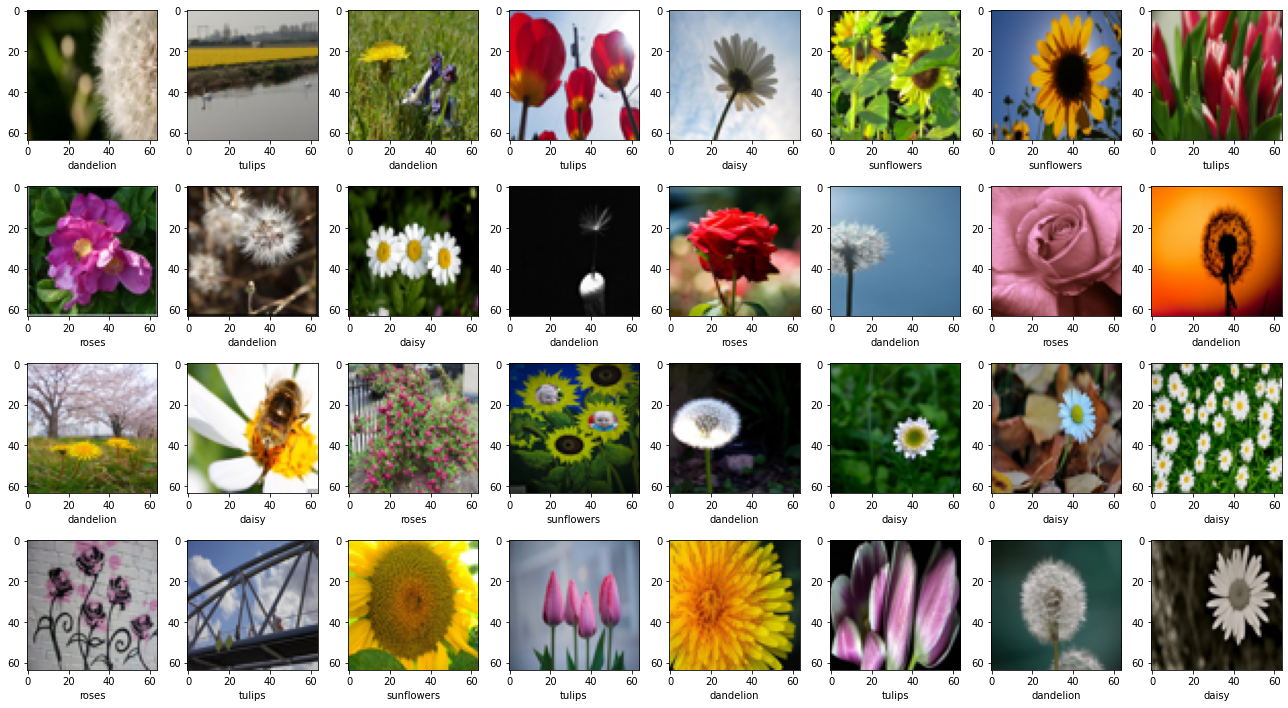

In [12]:
row, col = 4, 8
n_data_to_plot = row*col

#  plot image data
plt.figure(figsize=(18, 10))
for i in range(32):
    # extact image and it's lable from batch data
    image = sample_data[0][i]
    int_label = sample_data[1][i]

    # plot image
    plt.subplot(row, col, i+1)
    plt.imshow(image)
    plt.xlabel(INT_LABEL_TO_FLOWR_NAME[int_label])
plt.tight_layout()
plt.show()

In [13]:
class FlowerClassifire(tf.keras.Model):
    def __init__(self, num_class):
        super(FlowerClassifire, self).__init__()
        self.num_class = num_class

        # conv block 1
        self.conv_1 = layers.Conv2D(filters=64, kernel_size=3, activation='relu')
        self.max_pool_1 = layers.MaxPool2D(pool_size=2)

        # conv black 2
        self.conv_2 = layers.Conv2D(filters=64, kernel_size=3, activation='relu')
        self.max_pool_2 = layers.MaxPool2D(pool_size=2)

        # dense block
        self.flatten = layers.Flatten()
        self.dense_1 = layers.Dense(units=64, activation='relu')
        self.dropout = layers.Dropout(0.5)
        
        # classification layer
        self.dense_2 = layers.Dense(units=self.num_class, activation='softmax')
    
    def call(self, x):
        y = self.conv_1(x)
        y = self.max_pool_1(y)
        y = self.conv_2(y)
        y = self.max_pool_2(y)
        y = self.flatten(y)
        y = self.dense_1(y)
        y = self.dropout(y)
        y = self.dense_2(y)
        return y

In [14]:
# initialize subclass model
subclass_model = FlowerClassifire(num_class=5)

# compile the model
subclass_model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [15]:
history = subclass_model.fit(
    train_data,
    epochs=10,
    validation_data=valid_data
)

Epoch 1/10
51/51 [==============================] - 13s 250ms/step - loss: 1.4255 - accuracy: 0.3713 - val_loss: 1.2408 - val_accuracy: 0.4375
Epoch 2/10
51/51 [==============================] - 13s 250ms/step - loss: 1.2263 - accuracy: 0.4789 - val_loss: 1.1057 - val_accuracy: 0.5597
Epoch 3/10
51/51 [==============================] - 13s 247ms/step - loss: 1.1108 - accuracy: 0.5487 - val_loss: 1.0481 - val_accuracy: 0.5824
Epoch 4/10
51/51 [==============================] - 13s 249ms/step - loss: 1.0481 - accuracy: 0.5892 - val_loss: 0.9457 - val_accuracy: 0.6591
Epoch 5/10
51/51 [==============================] - 13s 246ms/step - loss: 0.9865 - accuracy: 0.6127 - val_loss: 0.9281 - val_accuracy: 0.6591
Epoch 6/10
51/51 [==============================] - 13s 246ms/step - loss: 0.9078 - accuracy: 0.6517 - val_loss: 0.8452 - val_accuracy: 0.6676
Epoch 7/10
51/51 [==============================] - 13s 252ms/step - loss: 0.8535 - accuracy: 0.6743 - val_loss: 0.8597 - val_accuracy: 0.6648

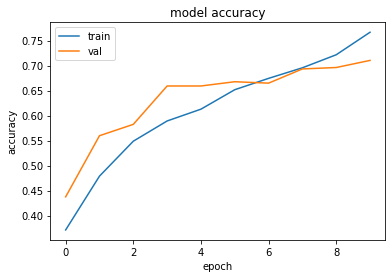

In [16]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()

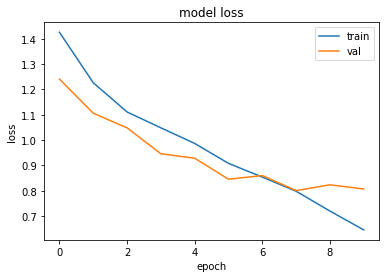

In [17]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'])
plt.show()